**IMPORT LIBRARY**

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.exceptions import ConvergenceWarning

**DOWNLOAD DATASET**

In [2]:
from google.colab import files
files.upload()

"""
Buat folder baru bernama kaggle untuk menyimpan API Token dari Kaggle.com
"""
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/

# Change permission of the site
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d "farhan999/tokopedia-product-reviews"

# Unzip file
!unzip -o tokopedia-product-reviews.zip

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/farhan999/tokopedia-product-reviews
License(s): MIT
  0% 0.00/1.17M [00:00<?, ?B/s]
100% 1.17M/1.17M [00:00<00:00, 494MB/s]
Archive:  tokopedia-product-reviews.zip
  inflating: tokopedia-product-reviews-2019.csv  


**LOAD DATASET**

In [3]:
tokped_reviews = pd.read_csv("/content/tokopedia-product-reviews-2019.csv")
tokped_reviews

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...
...,...,...,...,...,...,...,...,...,...
40602,40889,gak bisa ditutup.. ukuran gak pas..,1,olahraga,MINERAL WATER POT WATER PURIFIER 28 liter BIO ...,144442054,2,648559,https://www.tokopedia.com/pusatdermawand/miner...
40603,40890,Penjual krg peduli dan brg jelek. Brg yg dikir...,1,olahraga,PANCI PRESTO IDEALIFE 7 LITER - IL 707 &#40; I...,313781913,1,648559,https://www.tokopedia.com/pusatdermawand/panci...
40604,40891,"pelayanan kurang sigap, berhari2 dr nanya baik...",1,olahraga,EXCIDER BIKE 2 - sepeda fitnes magnetic lipat ...,71873370,1,648559,https://www.tokopedia.com/pusatdermawand/excid...
40605,40892,"barang yg dikirim tsk sesuai wrn, kl memang dr...",1,olahraga,TOTAL FITNES ALAT FITNESS SIT UP BENCH TOTAL &...,201690705,2,648559,https://www.tokopedia.com/pusatdermawand/total...


**NILAI KONDISI DATA**

In [4]:
tokped_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40607 entries, 0 to 40606
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    40607 non-null  int64 
 1   text          40607 non-null  object
 2   rating        40607 non-null  int64 
 3   category      40607 non-null  object
 4   product_name  40607 non-null  object
 5   product_id    40607 non-null  int64 
 6   sold          40593 non-null  object
 7   shop_id       40607 non-null  int64 
 8   product_url   40607 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.8+ MB


In [5]:
tokped_reviews.isna().sum()

,0
Unnamed: 0,0
text,0
rating,0
category,0
product_name,0
product_id,0
sold,14
shop_id,0
product_url,0


In [6]:
tokped_reviews.duplicated().sum()

np.int64(0)

**INSIGHT**

- Ditemukan missing value pada kolom sold sebanyak 14 data

- Dari kolom yang tersedia, akan diambil 2 kolom saja yaitu kolom **text dan rating** untuk dijadikan kolom baru bernama label

pada kolom text ditemukan:

*   **campuran penulisan antara huruf besar huruf kecil**
*   **komen yang menggunakan emoji**
*   **komen yang menggunakan karakter atau tanda baca > 1 secara berurutan**
*   Penggunaan 2 untuk mewakili **perulangan kalimat** seperti hati2
*   Kolem komen yang hanya berisikan **simbol atau tanda baca saja**

**PREPROCESSING DATA**

In [7]:
def remove_emoji(text):
  """
  Fungsi ini digunakan untuk menghapus emoji dam simbol kode Unicode yang ada di dalam text

  Args:
    text: Input dari kolom teks yang akan dibersikan

  Returns:
    str: String yang sudah bersih dari emoji dan simbol kode Unicode
  """
  emoji_pattern = re.compile("["
                            "\U0001F600-\U0001F64F" # Emoji
                            "\U0001F300-\U0001F5FF" # Simbol
                             "]+",
                             flags=re.UNICODE
                            )
  return emoji_pattern.sub(r'', str(text))

In [21]:
def load_slang_dict():
    """
    Fungsi ini mengembalikan kamus yang berisikan kata slang dan kata baku.

    Kamus ini mencakup:
    - Singkatan
    - Typo
    - Simbol
     - Karakter emoticon

    Args:
        None

    Returns:
        dict: Kamus slang custom yang berisi kata slang dan kata baku.
    """
    # Kamus slang custom
    kamus_baku = {
        # Kalimat
        "dgn": "dengan", "blum": "belum", "blm": "belum", "ndak": "tidak", "tsk": "tidak",
        "tdk": "tidak", "wrn": "warna", "krg": "kurang", "brg": "barang", "mantab": "mantap",
        "sy": "saya", "dscrbs": "deskripsi", "describe":" deskripsi", "hny": "hanya","sdh": "sudah",
        "dr": "dari", "bgmn":"bagaimana", "dech": " ", "deh": " ", "tp": "tapi","tpi": "tapi",
        "yg": "yang", "&": "dan", "\n": " ", "god.": "bagus", "kl": "kalau", "klo": "kalau",
        "smga": "semoga", "smoga": "semoga", "trus": "terus", "danamp;": "dan", "dos": "kotak",
        "dus": "kotak", "prosen": "proses", "thankss": "terima kasih", "thanks": "terima kasih",
        "thx": "terima kasih","seler": "penjual", "seller": "penjual", "paking": "kemasan",
        "peking": "kemasan","langanan": "langganan", "buat": "untuk", "pokok e": "pokoknya",
        "jos": "mantap", "pengriman": "pengiriman", "sih": " ", "gimana": "bagaimana",
        "gmn": "bagaimana", "apaan": "apa", "jlk": "jelek", "ih": " ", "nih": " ", "jd": "jadi",
        "gk": "tidak", "bgt": "sangat", "banget": "sangat", "dong": " ", "lah": " ",

        # Emoji
        ":)": " senang ", ":(": " sedih "
    }

    return kamus_baku

In [9]:
def remove_repeated_char(text):
  """
  Fungsi ini menggunakan regex untuk menemukan urutan karakter yang muncul lebih dari 1x
  secara berurutan. Pola (.) akan menangkap karakter dan \1+ akan mencocokan apakah karakter
  tersebut diulang satu kali atau lebih

  Args:
    text (string): Input teks yang akan dibersihkan

  Return:
    str:
  """
  pattern = re.compile(r'(.)\1+')
  return pattern.sub(r'\1', str(text))

In [10]:
def normalisasi_duplikasi(text):
  """
  Fungsi ini digunakan untuk merubah angka 2 pada kalimat (misal: "hati2") menjadi
  bentuk formal (misal: "hati-hati")

  Args:
    text (string): Input teks yang akan dibersihkan

  Return:
    str: Teks yang sudah dibersihkan
  """
  pattern = re.compile(r'([a-zA-Z]+)2')
  return pattern.sub(r'\1-\1', str(text))

In [24]:
def remove_punctuation(text):
    """
    Menghapus SEMUA tanda baca KECUALI hyphen (-) internal
    dan menggantinya dengan spasi.
    """
    pattern = re.compile(r'[^\w\s-]')
    return pattern.sub(' ', str(text))

In [12]:
def labeling(rating):
  """
  Fungsi ini mengambil nilai integer dari kolom rating dan mengubahnya menjadi tiga
  label string:
    - positif
    - netral
    - negatif

  Args:
    rating (int): Nilai integer dari kolom rating yang akan diubah menjadi label

  Returns:
    str: Label sentiment ('positif', 'netral', 'negatif') berdasarkan nilai rating
  """
  if rating >= 4:
    return "positif"
  elif rating == 3:
    return "netral"
  elif rating <=2:
    return "negatif"

In [13]:
# Hapus kolom yang tidak digunakan
tokped_cleaned = tokped_reviews.drop(columns=['Unnamed: 0', 'category', 'product_name', 'product_id', 'sold', 'shop_id', 'product_url'])

In [14]:
# Ubah menjadi huruf kecil untuk semua isi kolom text
tokped_cleaned['text'] = tokped_cleaned['text'].str.lower()

# Hapus baris yang tidak berisikan huruf sama sekali
mask = tokped_cleaned['text'].apply(lambda x: bool(re.search('[a-zA-Z]', str(x))))
tokped_cleaned = tokped_cleaned[mask]

In [15]:
# Menerapkan remove emoji
tokped_cleaned['text'] = tokped_cleaned['text'].apply(remove_emoji)

In [22]:
# Load kamus
kamus_baku = load_slang_dict()

# emoji :) dan :( terbaca sebagai string bukan perintah
kamus_baku = {re.escape(k): v for k, v in kamus_baku.items()}

# Menerapkan normalisasi kata slang
tokped_cleaned['text'] = tokped_cleaned['text'].replace(kamus_baku, regex=True)

In [25]:
tokped_cleaned['text'] = tokped_cleaned['text'].apply(remove_punctuation) # Hapus tanda baca

In [26]:
# Menghapus karakter yang muncul > 1 secara berurutan
tokped_cleaned['text'] = tokped_cleaned['text'].apply(remove_repeated_char)

# Normalisasi angka 2 pada kalimat menjadi formal
tokped_cleaned['text'] = tokped_cleaned['text'].apply(normalisasi_duplikasi)

In [27]:
# Buat kolom baru bernama label
tokped_cleaned['label'] = tokped_cleaned['rating'].apply(labeling)

# Hapus kolom rating karena sudah tidak digunakan lagi
tokped_cleaned = tokped_cleaned.drop(columns=['rating'])

In [28]:
tokped_cleaned.head()

,text,label
0,barang sesuai pesanan dan cepat sampai,positif
1,barang bagus harga murah,positif
2,paket rapi mantap cepat sampe ke tujuan,positif
3,ya saya puas dengan barangnya,positif
4,responya luar biasa b mantap,positif


In [29]:
# Simpan dataset yang sudah bersihkan ke format csv
tokped_cleaned.to_csv("tokopedia_reviews_clean.csv", index=False)

In [30]:
tokped_cleaned = pd.read_csv("/content/tokopedia_reviews_clean.csv")

In [31]:
# Label Encoding kolom label
label_mapping = {
    "positif": 2,
    "netral": 1,
    "negatif": 0
}

# Terapkan Encodin
tokped_cleaned['label'] = tokped_cleaned['label'].map(label_mapping)

**Splitting Dataset**

In [32]:
tokped_cleaned.head()

,text,label
0,barang sesuai pesanan dan cepat sampai,2
1,barang bagus harga murah,2
2,paket rapi mantap cepat sampe ke tujuan,2
3,ya saya puas dengan barangnya,2
4,responya luar biasa b mantap,2


In [33]:
# Memisahkan antara kolom target (y) dan kolom input (X)
X = tokped_cleaned['text']
y = tokped_cleaned['label']

# splitting 80% data latih dan 20% data test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

**SENTENCE-TRANSFOMER**

In [34]:
# Load model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Ubah data latih di X_train kedalam bentuk vektor
X_train_embedding = model.encode(X_train.tolist(), show_progress_bar=True)

# Ubah data uji di X_test kedalam bentuk vektor
X_test_embedding = model.encode(X_test.tolist(), show_progress_bar=True)

print(f"Data Latih: {X_train_embedding.shape}")
print(f"Data Uji: {X_test_embedding.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1011 [00:00<?, ?it/s]

Batches:   0%|          | 0/253 [00:00<?, ?it/s]

Data Latih: (32325, 384)
Data Uji: (8082, 384)


**TRAIN MODEL**

In [35]:
# Abaikan jumlah max_iter jika mendekati titik optimal
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load model logisticRegression
lr_classifier = LogisticRegression(max_iter=100, random_state=42)

# Train model
lr_classifier.fit(X_train_embedding, y_train)

# Hasil Akurasi data latih
y_train_pred = lr_classifier.predict(X_train_embedding)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Akurasi Data Latih: {train_accuracy:.4f}")

# Hasil evaluasi
print(classification_report(y_train, y_train_pred, target_names=["negatif (0)",
                                                          "netral (1)",
                                                          "positif (2)"]
                            ))

Akurasi Data Latih: 0.9402
              precision    recall  f1-score   support

 negatif (0)       0.64      0.41      0.50       738
  netral (1)       0.49      0.06      0.11      1445
 positif (2)       0.95      1.00      0.97     30142

    accuracy                           0.94     32325
   macro avg       0.69      0.49      0.53     32325
weighted avg       0.92      0.94      0.92     32325



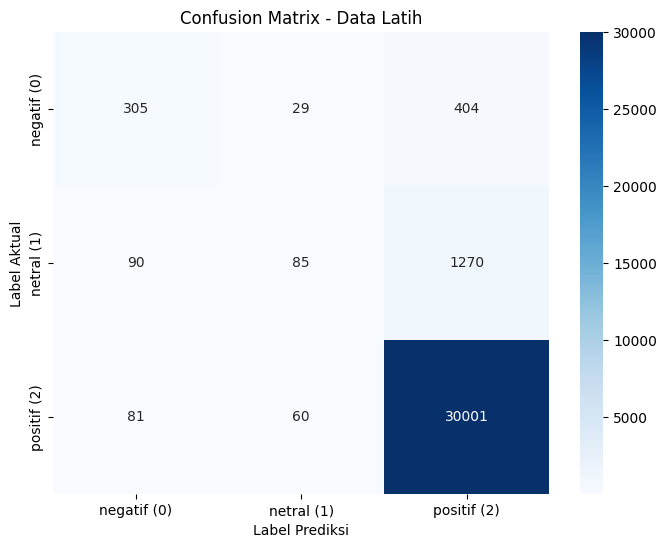

In [36]:
# Inisialisasi confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Label
labels = ["negatif (0)", "netral (1)", "positif (2)"]

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.title("Confusion Matrix - Data Latih")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Aktual")
plt.show()

**TEST MODEL**

In [37]:
# Prediksi model pada data uji
y_pred = lr_classifier.predict(X_test_embedding)

# Hasil Akurasi data uji
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Data Uji: {test_accuracy:.4f}")

# Hasil evaluasi
print(classification_report(y_test, y_pred, target_names=["negatif (0)",
                                                          "netral (1)",
                                                          "positif (2)"]
                            ))

Akurasi Data Uji: 0.9348
              precision    recall  f1-score   support

 negatif (0)       0.57      0.30      0.39       184
  netral (1)       0.19      0.02      0.04       362
 positif (2)       0.94      0.99      0.97      7536

    accuracy                           0.93      8082
   macro avg       0.57      0.44      0.47      8082
weighted avg       0.90      0.93      0.91      8082



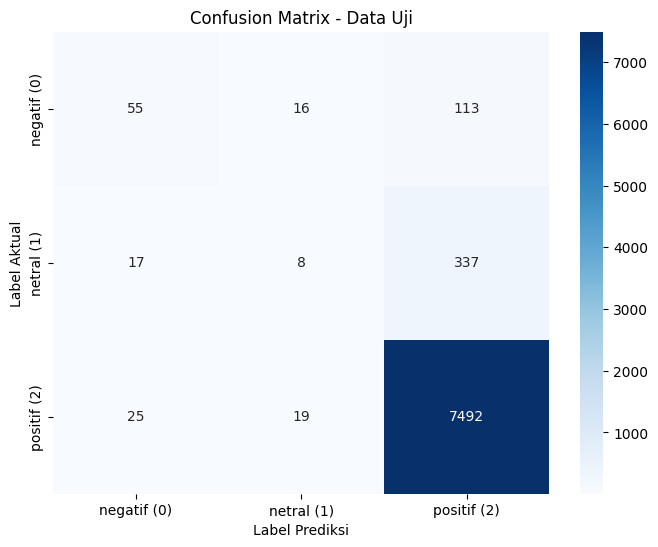

In [38]:
# Inisialisasi confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Label
labels = ["negatif (0)", "netral (1)", "positif (2)"]

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.title("Confusion Matrix - Data Uji")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Aktual")
plt.show()

**CONTOH OUTPUT**

In [ ]:
def preprocessing_text(text):
  """
  Alur preprocessing yang disesuaikan dengan preprocessing sebelumnya
  """
  text = str(text).lower() # Ubah menjadi lowercase
  text = remove_emoji(text) # Hapus emoji dari text
  text = remove_repeated_char(text) # Hapus karakter, tanda baca yg muncul > 1x berurutan
  text = normalisasi_duplikasi(text) # ubah kalimat hati2 -> hati-hati

  # Ubah kata slang menjadi bentuk baku
  temp_series = pd.Series([text])
  temp_series = temp_series.replace(kamus_baku, regex=True)
  text = temp_series.iloc[0]

  text = text.strip()
  text = re.sub(r'\s+', ' ', text)

  return text

In [ ]:
label_map = {
    2: "positif",
    1: "netral",
    0: "negatif"
}

def sentiment(text_input):
  print(f"Input: {text_input}")

  # Panggil fungsi preprocessing_text
  clean_text = preprocessing_text(text_input)

  # Buat embedding (Encoder)
  embedding_text = model.encode([clean_text])

  # Prediksi inputan text
  prediction = lr_classifier.predict(embedding_text)

  # Hasil prediksi
  label = prediction[0]

  # Ubah kedalam bentuk string
  label_string = label_map.get(label, "Unknown")

  print(f"Prediksi: {label_string} (Kode: {label})")

  return label, label_string

In [ ]:
sentiment("Barangnya bagus, cuman respon sellernya jelek banget")

Input: Barangnya bagus, cuman respon sellernya jelek banget
Prediksi: positif (Kode: 2)


(np.int64(2), 'positif')

**SAVE MODEL**

In [39]:
import joblib

model_path = "model_classifier.joblib"

joblib.dump(lr_classifier, model_path)

['model_classifier.joblib']

In [40]:
model_encoder_path = "sentence_transformer"

model.save(model_encoder_path)

In [41]:
!zip -r sentence_transformer.zip sentence_transformer

  adding: sentence_transformer/ (stored 0%)
  adding: sentence_transformer/README.md (deflated 59%)
  adding: sentence_transformer/config.json (deflated 48%)
  adding: sentence_transformer/config_sentence_transformers.json (deflated 40%)
  adding: sentence_transformer/model.safetensors (deflated 8%)
  adding: sentence_transformer/unigram.json (deflated 74%)
  adding: sentence_transformer/1_Pooling/ (stored 0%)
  adding: sentence_transformer/1_Pooling/config.json (deflated 59%)
  adding: sentence_transformer/tokenizer.json (deflated 76%)
  adding: sentence_transformer/sentence_bert_config.json (deflated 9%)
  adding: sentence_transformer/special_tokens_map.json (deflated 85%)
  adding: sentence_transformer/modules.json (deflated 53%)
  adding: sentence_transformer/tokenizer_config.json (deflated 74%)
